In [1]:
import sys
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import boda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font="monospace")

from scipy import spatial
from scipy.cluster import hierarchy

from boda.common.utils import generate_all_onehots, generate_all_onehots
from boda.common.metrics import jaccard_index, euclidean_distance

In [2]:
all_octamers  = boda.common.utils.generate_all_onehots(k=8).float()
pentamer_scan = boda.common.utils.KmerFilter(k=5)
pentamer_scan.cuda()

KmerFilter()

In [3]:
octamer_loader  = torch.utils.data.DataLoader( all_octamers, batch_size=1024 )

In [4]:
results = []
for x in octamer_loader:
    batch = x.cuda()
    results.append( pentamer_scan( batch ).max(dim=-1)[0].cpu()  )
    
results = torch.cat(results, dim=0)

In [5]:
results.shape

torch.Size([65536, 1024])

In [6]:
%%time

jac_res = jaccard_index(results.cuda(), results.cuda(), max_batch_size=512, dtype=torch.half)
jac_res.shape

CPU times: user 6min 5s, sys: 9.61 s, total: 6min 15s
Wall time: 4min 50s


torch.Size([65536, 65536])

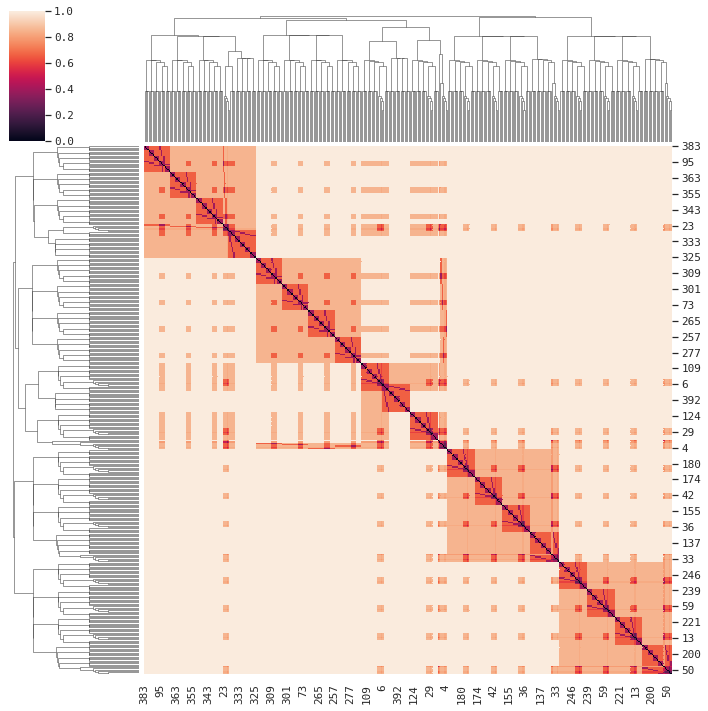

In [7]:
DF_dism = 1 - jac_res[:400,:400].cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [6]:
%%time

euc_res = euclidean_distance(results.cuda(), results.cuda(), max_batch_size=512, dtype=torch.half)
euc_res.shape

CPU times: user 3min 26s, sys: 10.1 s, total: 3min 36s
Wall time: 2min 9s


torch.Size([65536, 65536])

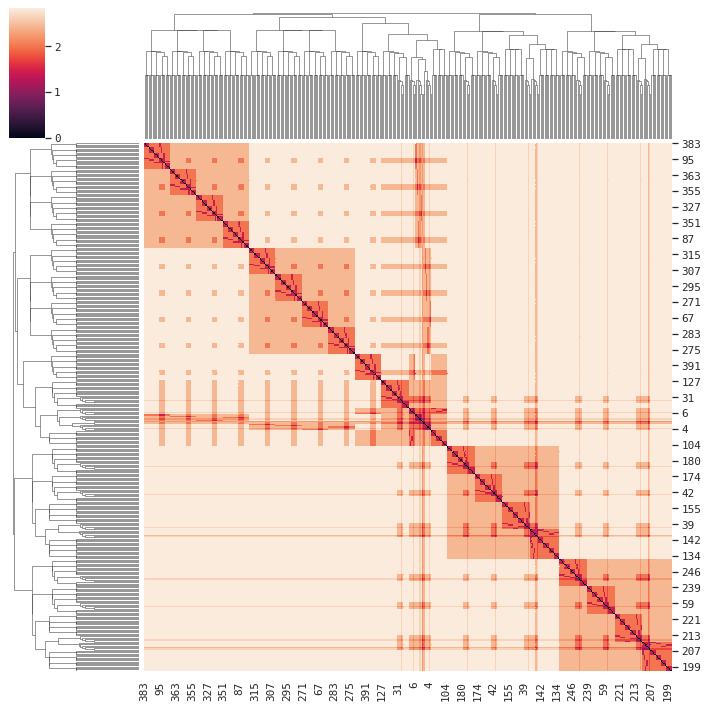

In [9]:
DF_dism = euc_res[:400,:400].cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [9]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

tensor([[1.0000, 0.5000, 0.5000, 0.5000, 0.3333],
        [0.5000, 1.0000, 0.3333, 0.3333, 0.6667],
        [0.5000, 0.3333, 1.0000, 0.3333, 0.2500],
        [0.5000, 0.3333, 0.3333, 1.0000, 0.2500],
        [0.3333, 0.6667, 0.2500, 0.2500, 1.0000]])

In [4]:
for batch in octamer_loader:
    break

In [6]:
batch.shape

torch.Size([1024, 4, 8])

In [10]:
x = torch.randn(5,1,7) > 0
y = torch.randn(1,2,7) > 0

In [11]:
x

tensor([[[ True, False, False, False, False,  True,  True]],

        [[ True, False, False, False, False, False, False]],

        [[False, False, False,  True,  True,  True, False]],

        [[ True, False,  True,  True,  True, False,  True]],

        [[False, False, False,  True, False, False, False]]])

In [12]:
y

tensor([[[False,  True,  True,  True, False, False, False],
         [ True,  True,  True, False,  True, False, False]]])

In [13]:
x.half() - y.half()

tensor([[[ 1., -1., -1., -1.,  0.,  1.,  1.],
         [ 0., -1., -1.,  0., -1.,  1.,  1.]],

        [[ 1., -1., -1., -1.,  0.,  0.,  0.],
         [ 0., -1., -1.,  0., -1.,  0.,  0.]],

        [[ 0., -1., -1.,  0.,  1.,  1.,  0.],
         [-1., -1., -1.,  1.,  0.,  1.,  0.]],

        [[ 1., -1.,  0.,  0.,  1.,  0.,  1.],
         [ 0., -1.,  0.,  1.,  0.,  0.,  1.]],

        [[ 0., -1., -1.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1., -1.,  0.,  0.]]], dtype=torch.float16)